Click [here](https://tensor4all.org/T4AJuliaTutorials/_sources/ipynbs/quantics2d.ipynb) to download the notebook locally.


# Quantics TCI of multivariate function


In [1]:
import TensorCrossInterpolation as TCI
import QuanticsGrids: DiscretizedGrid, origcoord_to_quantics, origcoord_to_grididx, grididx_to_origcoord
using QuanticsTCI
using PythonPlot: pyplot as plt
using PythonPlot: Figure
using PythonCall: Py
_display(fig::Figure) = isinteractive() ? (fig; plt.show(); nothing) : Base.display(fig)
_display(fig::Py) = _display(Figure(fig))
# pythonplot() # use pythonplot backend for plotting
using LaTeXStrings

## Artificial function with widely different length scales

As in the univariate case, we first demonstrate the multivariate case on an artificial function with widely different length scales:


In [2]:
f(x, y) = (exp(-0.4 * (x^2 + y^2)) + 1 + sin(x * y) * exp(-x^2) +
           cos(3 * x * y) * exp(-y^2) + cos(x + y)) +
           0.05 * cos(1 / 0.001 * (0.2 * x - 0.4 * y)) +
           0.0005 * cos(1 / 0.0001 * (-0.2 * x + 0.7 * y)) +
           1e-5 * cos(1 / 1e-7 * (20 * x))

f (generic function with 1 method)

To construct a 2D quantics grid, put `2` in the type parameter of `DiscretizedGrid`, and use tuples to specify lower and upper limits in each dimension:

In [3]:
R = 40
gr = DiscretizedGrid{2}(R, (-5, -5), (5, 5))

DiscretizedGrid{2}(40, (-5.0, -5.0), (5.0, 5.0), 2, :fused, false)

To illustrate the different length scales, we show a series of progressively smaller parts of the function domain in the following.

In [4]:
function myplotheatmap(ax, func, xlim::Tuple, ylim::Tuple; xlim_box=nothing, ylim_box=nothing, cmap="inferno")
    x = LinRange(xlim..., 400)
    y = LinRange(ylim..., 400)
    s = ax.pcolormesh(y, x, func.(x, y'), cmap=cmap)
    if !isnothing(xlim_box) && !isnothing(ylim_box)
        ax.plot(
            [ylim_box[1], ylim_box[1], ylim_box[2], ylim_box[2], ylim_box[1]],
            [xlim_box[1], xlim_box[2], xlim_box[2], xlim_box[1], xlim_box[1]],
            color="lightgreen", lw=2, label="",
        )
    end
    plt.colorbar(s, ax=ax, orientation="vertical", pad=0.11)
    ax.set_xlabel(raw"$x$")
    ax.set_ylabel(raw"$y$")
    ax
end

function myplotheatmap(func, xlim::Tuple, ylim::Tuple; xlim_box=nothing, ylim_box=nothing, cmap="inferno")
    fig, ax = plt.subplots()
    myplotheatmap(ax, func, xlim, ylim; xlim_box, ylim_box, cmap)
    _display(fig)
end

myplotheatmap (generic function with 2 methods)

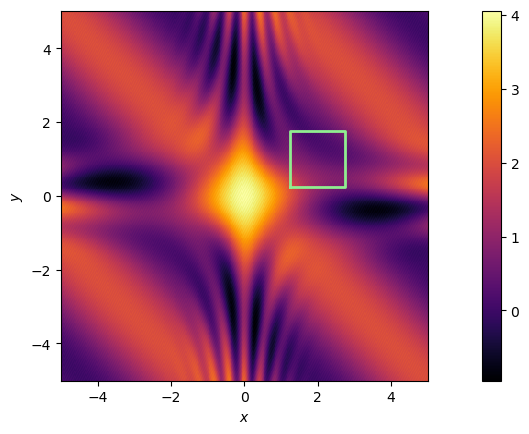

In [5]:
myplotheatmap(f, (-5, 5), (-5, 5), xlim_box=(0.25, 1.75), ylim_box=(1.25, 2.75), cmap="inferno")

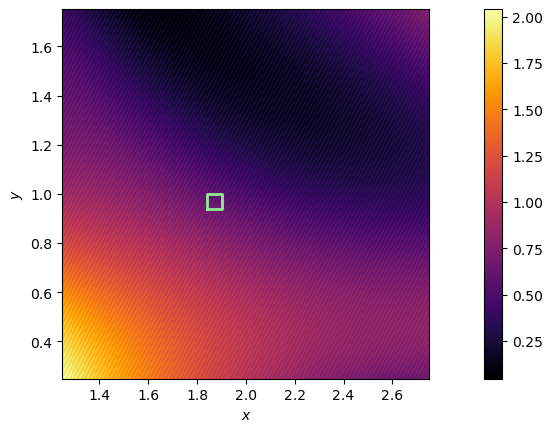

In [6]:
myplotheatmap(f, (0.25, 1.75), (1.25, 2.75), xlim_box=(0.94, 1.0), ylim_box=(1.84, 1.9))

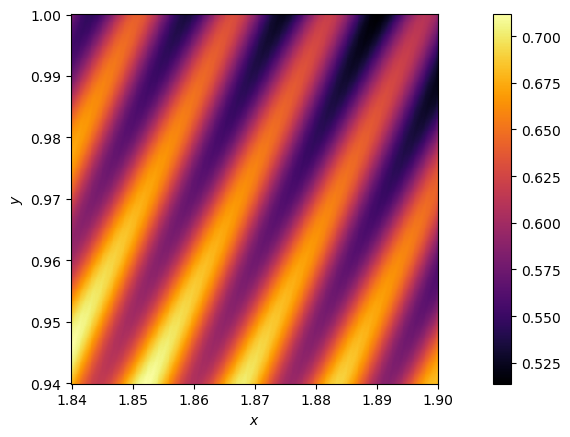

In [7]:
myplotheatmap(f, (0.94, 1.0), (1.84, 1.9), xlim_box=(0.97, 0.97 + 1e-7), ylim_box=(1.88, 1.88 + 1e-7))

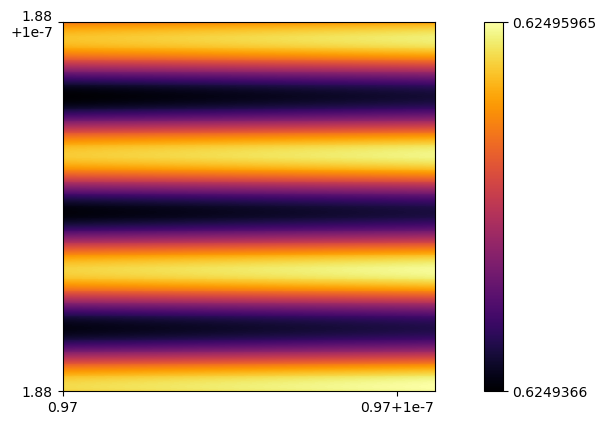

In [8]:
fig, ax = plt.subplots()
xs = LinRange(0.97, 0.97 + 1e-7, 400)
ys = LinRange(1.88, 1.88 + 1e-7, 400)
s = ax.pcolormesh(xs, ys, f.(xs, ys'), cmap="inferno")
cbar = fig.colorbar(s, ax=ax, orientation="vertical", pad=0.1)
cbar.ax.set_yticks([0.6249366, 0.62495965])
cbar.ax.set_yticklabels(["0.6249366", "0.62495965"])

ax.set_xticks([0.97, 0.97 + 0.9e-7])
ax.set_xticklabels([0.97, "0.97+1e-7"])
ax.set_yticks([1.88, 1.88 + 1e-7])
ax.set_yticklabels([1.88, "1.88" * "\n" * "+1e-7"])

_display(fig)

We can now obtain a QTT for `f` in the same way as in the 1D case:

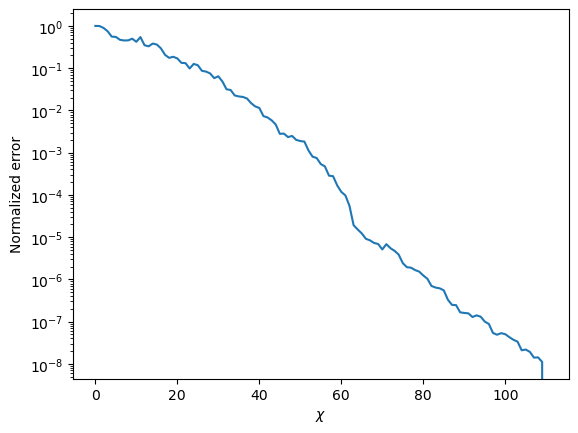

In [9]:
# Construct 2D quantics
fig, ax = plt.subplots()
qtci, ranks, errors = quanticscrossinterpolate(Float64, f, gr)
ax.plot(qtci.tci.pivoterrors ./ qtci.tci.maxsamplevalue)
ax.set_xlabel(L"\chi")
ax.set_ylabel("Normalized error")
ax.set_yscale("log")
_display(fig)

Checking the error on the same slices as before, we see that the approximation is accurate everywhere:

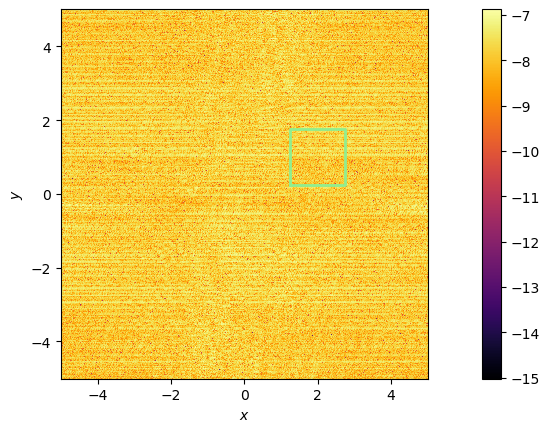

In [10]:
# Function that evaluates log10 of the interplation error at (x, y)
function errflog10(x, y)
    i = origcoord_to_grididx(gr, (x, y))
    log10(abs(f(grididx_to_origcoord(gr, i)...) - qtci(i)))
end

eps = 1e-10
myplotheatmap(errflog10, (-5, 5 - eps), (-5, 5 - eps), xlim_box=(0.25, 1.75), ylim_box=(1.25, 2.75))

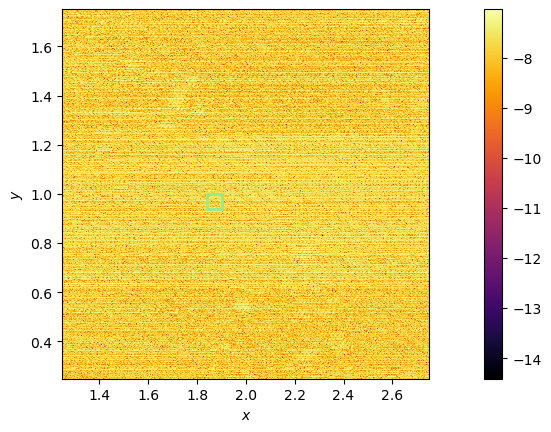

In [11]:
myplotheatmap(errflog10, (0.25, 1.75), (1.25, 2.75), xlim_box=(0.94, 1.0), ylim_box=(1.84, 1.9))

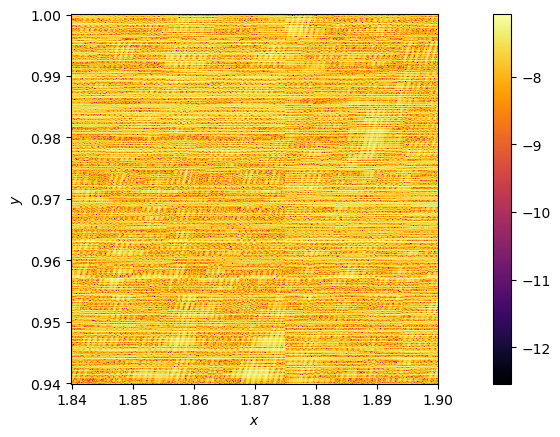

In [12]:
myplotheatmap(errflog10, (0.94, 1.0), (1.84, 1.9), xlim_box=(0.97, 0.97 + 1e-7), ylim_box=(1.88, 1.88 + 1e-7))

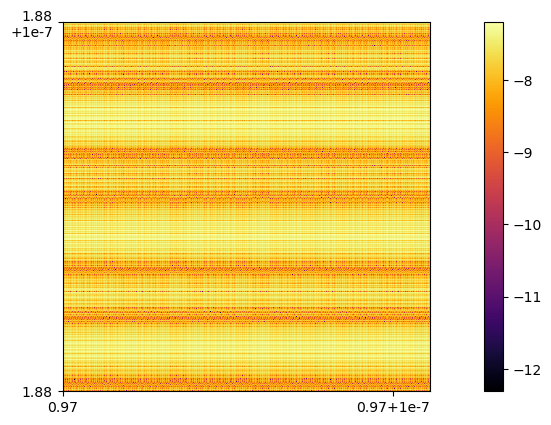

In [13]:
fig, ax = plt.subplots()
xs = LinRange(0.97, 0.97 + 1e-7, 400)
ys = LinRange(1.88, 1.88 + 1e-7, 400)
s = ax.pcolormesh(xs, ys, errflog10.(xs, ys'), cmap="inferno")
fig.colorbar(s, ax=ax, orientation="vertical", pad=0.11)
ax.set_xticks([0.97, 0.97 + 0.9e-7])
ax.set_xticklabels([0.97, "0.97+1e-7"])
ax.set_yticks([1.88, 1.88 + 1e-7])
ax.set_yticklabels([1.88, "1.88" * "\n" * "+1e-7"])

_display(fig)

In [14]:
println("Number of sampled points ", length(TCI.cachedata(qtci.quanticsfunction)))

Number of sampled points 795439
